###**Downloading and Unziping the data via kaggle API**

In [42]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d shenba/time-series-datasets

  0% 0.00/19.2k [00:00<?, ?B/s]
100% 19.2k/19.2k [00:00<00:00, 20.6MB/s]


In [43]:
!unzip time-series-datasets.zip

Archive:  time-series-datasets.zip
  inflating: Electric_Production.csv  
  inflating: daily-minimum-temperatures-in-me.csv  
  inflating: monthly-beer-production-in-austr.csv  
  inflating: sales-of-shampoo-over-a-three-ye.csv  


###**Importing Necessary Libraries**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

###**Importing the data**

In [45]:
data = pd.read_csv("monthly-beer-production-in-austr.csv", index_col='Month', parse_dates=True)
data.columns = ["Production"]
print(data.shape)

(476, 1)


###**Basic EDA**

In [46]:
data.head()

,Production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [47]:
data.tail()

,Production
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


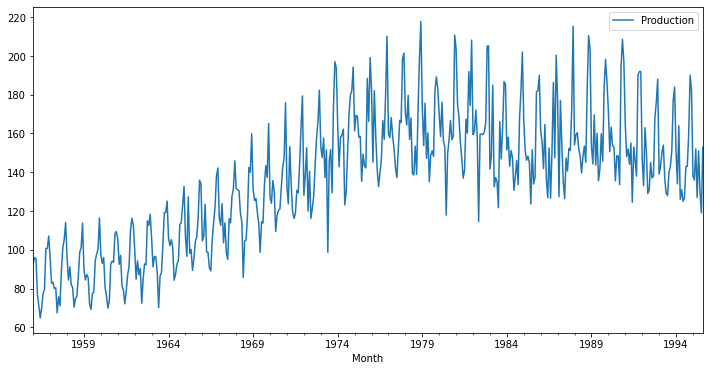

In [48]:
data.plot(figsize=(12,6))
plt.show()

###**Visualising the time series**

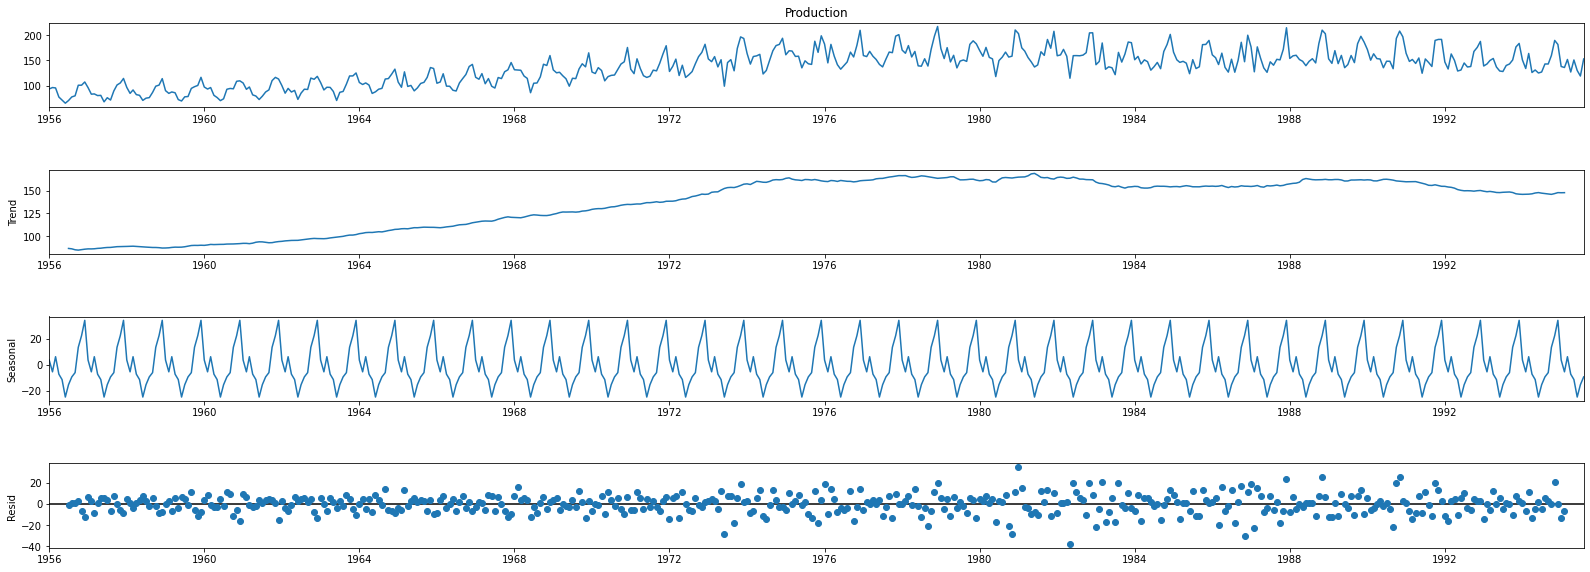

In [49]:
decomposed = seasonal_decompose(data['Production'])
fig = decomposed.plot()
fig.set_size_inches((25,9))
fig.show()

###**Preparing the series for modeling**

In [50]:
train = data[:'1992-12-31']
test = data['1993-01-01':]

In [51]:
print("Shape of training set: ", train.shape)
print("Shape of testing set: ", test.shape)

Shape of training set:  (444, 1)
Shape of testing set:  (32, 1)


In [52]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [53]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [54]:
n_months = 12
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

###**LSTM Model**

In [55]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_months, 1)),
    tf.keras.layers.LSTM(100, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(25, activation='tanh'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 78,626
Trainable params: 78,626
Non-trainable params: 0
_________________________________________________________________


In [56]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", verbose=1, patience=2)
history = model.fit(generator, epochs=10, callbacks=[early_stop])

Epoch 1/10
432/432 [==============================] - 7s 8ms/step - loss: 0.0213
Epoch 2/10
432/432 [==============================] - 4s 8ms/step - loss: 0.0167
Epoch 3/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0143
Epoch 4/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0106
Epoch 5/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0106
Epoch 6/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0091
Epoch 7/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0079
Epoch 8/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0087
Epoch 9/10
432/432 [==============================] - 3s 7ms/step - loss: 0.0085
Epoch 9: early stopping


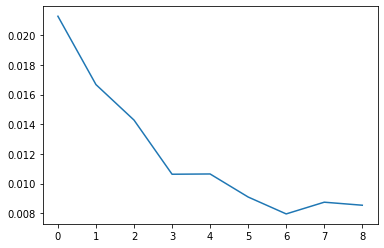

In [57]:
plt.plot(history.history['loss'])
plt.show()

###**Model Evaluation**

In [58]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

1/1 [==============================] - 1s 938ms/step


array([[0.5425047]], dtype=float32)

In [59]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

1/1 [==============================] - 0s 15ms/step


In [60]:
test['LSTM_predictions'] = scaler.inverse_transform(test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


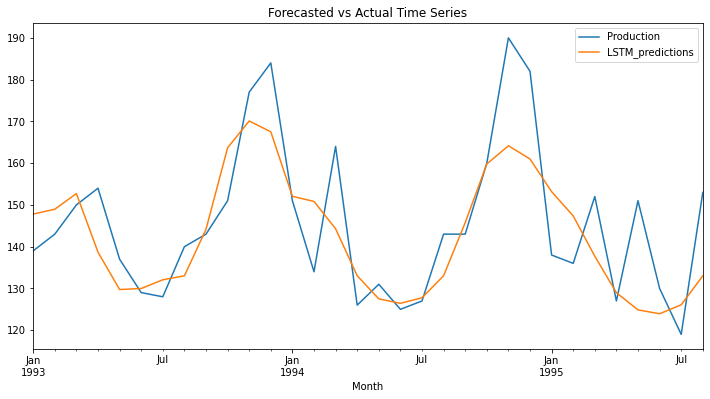

In [61]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()